In [1]:
rm(list = ls())
library(amap)
library(parallelDist)
library(qlcMatrix)
library(doParallel)
library(foreach)

source("source.R")
source("experiments/syntheticGenerator.R")

#setup parallel backend to use many processors
cores=detectCores()
cl <- makeCluster(cores[1]-1) #not to overload your computer
registerDoParallel(cl)

Loading required package: Matrix

Loading required package: slam

Loading required package: sparsesvd

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel

Loading required package: SCCI

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: pcalg

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘pcalg’”
Loading required package: Rgraphviz

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘Rgraphviz’”


In [2]:
experTrigger = function(exper, xind, yind, zinds, isCat, trueI){
    steps = 1:10
    loops = 1:2
    fact = 100

    CMI_mean_vec = data.frame(Samples=steps*fact, FP=rep(0, length(steps)), GAVK1=rep(0, length(steps)), GAVK2=rep(0, length(steps)), MS=rep(0, length(steps)), Histo_LH=rep(0, length(steps)), Histo_CHI99=rep(0, length(steps)))
    CMI_meanse_vec = data.frame(Samples=steps*fact, FP=rep(0, length(steps)), GAVK1=rep(0, length(steps)), GAVK2=rep(0, length(steps)), MS=rep(0, length(steps)), Histo_LH=rep(0, length(steps)), Histo_CHI99=rep(0, length(steps)))
    
    
    index = 1
    set.seed(2233)

    for(s in steps){
        n = s * fact
        
        # kNN
        estimatesKnn = foreach(l = loops, .combine=rbind, .packages = c('parallelDist','qlcMatrix','dplyr','MASS')) %dopar% {
            source("kNN.R")
            dd = exper(n)
            KNN.estimates_Parall(data=dd, xind=xind, yind=yind, zinds=zinds, isCat=isCat)
        }
        for(i in 1:4){
            CMI_mean_vec[index,i+1] = mean(estimatesKnn[,i])
            CMI_meanse_vec[index,i+1] = sum((estimatesKnn[,i] - trueI)^2) / length(loops)
        }
        
        # Histo
        estimatesHistoCMI = data.frame(LH=rep(0, length(loops)), Chisq99=rep(0, length(loops)))
        for(l in loops){
            dd = exper(n)
            estimate = CMI.estimates(data=dd, xind=xind,yind=yind,zinds=zinds,isCat=isCat,logE=T)
            estimatesHistoCMI[l,1] = estimate[[1]] / n ## pure likelihood
            estimatesHistoCMI[l,2] = max((estimate[[1]] + estimate[[2]]) / n,0)
        }
        for(i in 1:2){
            CMI_mean_vec[index,i+5] = mean(estimatesHistoCMI[,i])
            CMI_meanse_vec[index,i+5] = sum((estimatesHistoCMI[,i] - trueI)^2) / length(loops)
        }
        
        index = index + 1
    }
    
    return(CMI_meanse_vec)
} 

In [3]:
draw_MSE = function(res){
    n = seq(100,1000,100)
    plot(n, res[,2],
    ylab="Mean square error",
    main="MSE",
    ylim=c(min(res[,2:6]),max(res[,2:6])),
    type="l",
    lwd=3,
    col="#7fc97f")
    lines(n,res[,3], lwd=3, col="#beaed4")
    lines(n,res[,4], lwd=3, col="#fdc086")
    lines(n,res[,5], lwd=3, col="#636363")
    lines(n,res[,6], lwd=3, col="#386cb0")
    lines(n,res[,7], lwd=3, col="#f0027f")
    legend("topleft",
    c("FP","GAVK1","GAVK2", "MS", "Histo_LH", "Histo_Chisq99"),
    fill=c("#7fc97f", "#beaed4", "#fdc086", "#636363", "#386cb0", "#f0027f")
          )
}

EX.1.a

X ~ Continuous Unif(0, 4)  

Y = X + NoiseY  

Z = 2X + NoiseZ     

(X, Y, Z) ~ (Continuous, Continuous, Continuous)

I(Y;Z|X) = 0

In [4]:
EX1.a = function(n){
    x = runif(n, min=0, max=4)
    y = rep(0,n)
    z = rep(0,n)
    for(i in 1:n){
        y[i] = x[i] + rnorm(1)
        z[i] = 2*x[i] + rnorm(1)
      }
  return(data.frame(x,y,z))
}

In [5]:
res_EX1.a  = experTrigger(exper=EX1.a, xind=c(2), yind=c(3), zinds=c(1), isCat=c(), trueI=0)

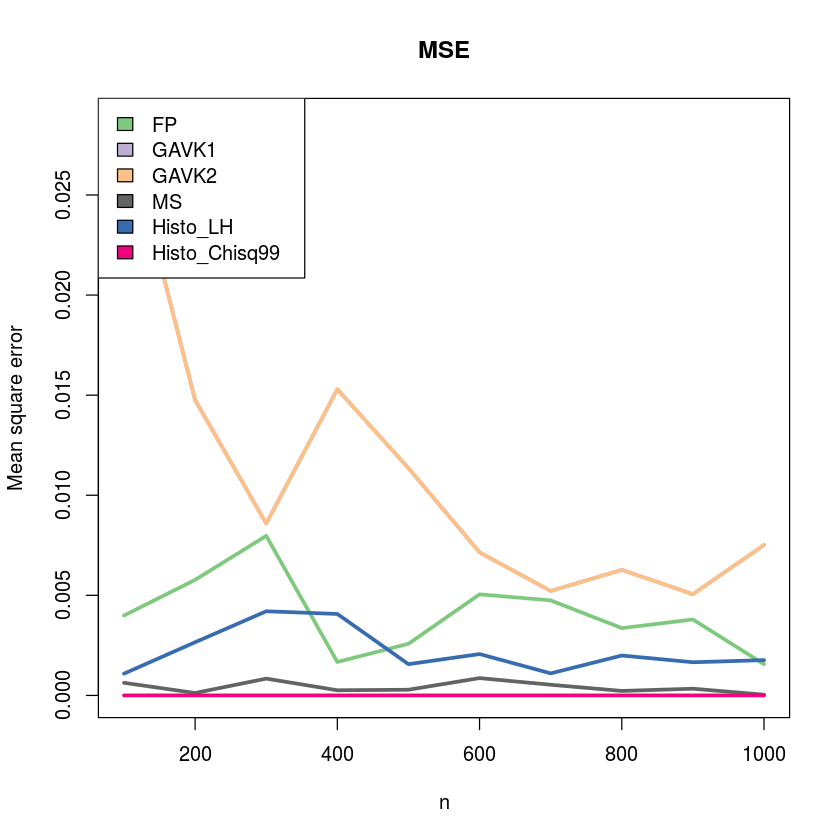

In [6]:
draw_MSE(res=res_EX1.a)

EX.1.b

X ~ Discrete Unif(0, 4)      

Y = X + NoiseY     

Z = 2X + NoiseZ

(X, Y, Z)~(Discrete, Discrete, Discrete)

I(Y;Z|X) = 0

In [7]:
EX1.b = function(n){
    x = sample(0:4,n,replace=T)
    y = rep(0,n)
    z = rep(0,n)
    for(i in 1:n){
        y[i] = round(x[i] + rnorm(1))
        if(y[i]>4){
            y[i] = 4
        }
        if(y[i]<0){
            y[i] = 0
        }
        z[i] = round(2*x[i] + rnorm(1))
        if(z[i]>8){
            z[i] = 8
        }
        if(z[i]<0){
            z[i] = 0
        }
      }
  return(data.frame(x,y,z))
}

In [8]:
res_EX1.b  = experTrigger(exper=EX1.b, xind=c(2), yind=c(3), zinds=c(1), isCat=c(1:3), trueI=0)

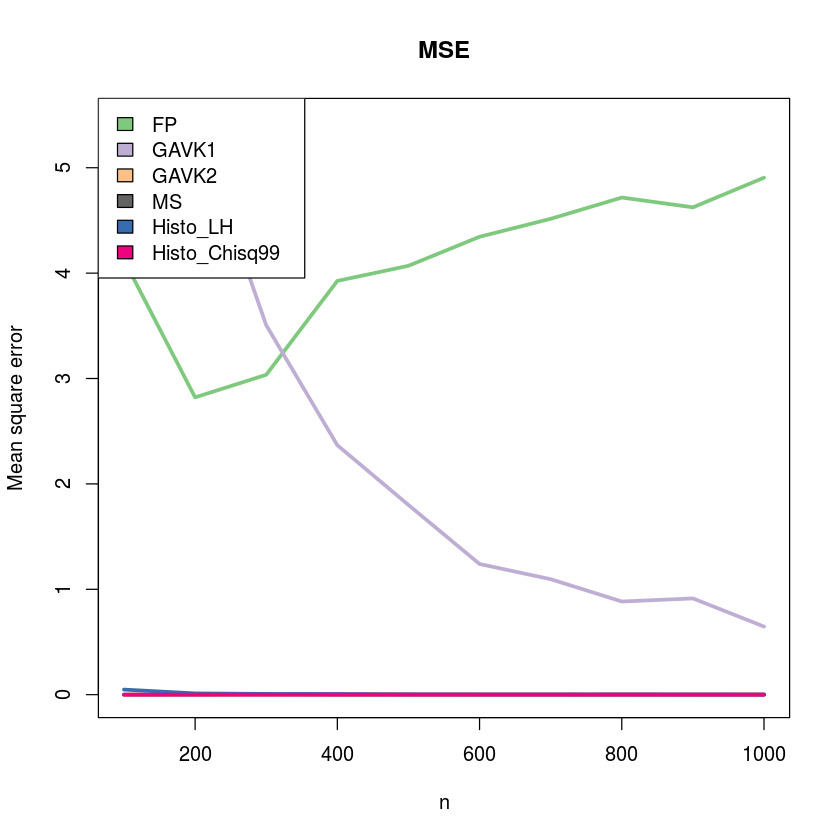

In [9]:
draw_MSE(res=res_EX1.b)

FP and GAVK1 have large mean square error.

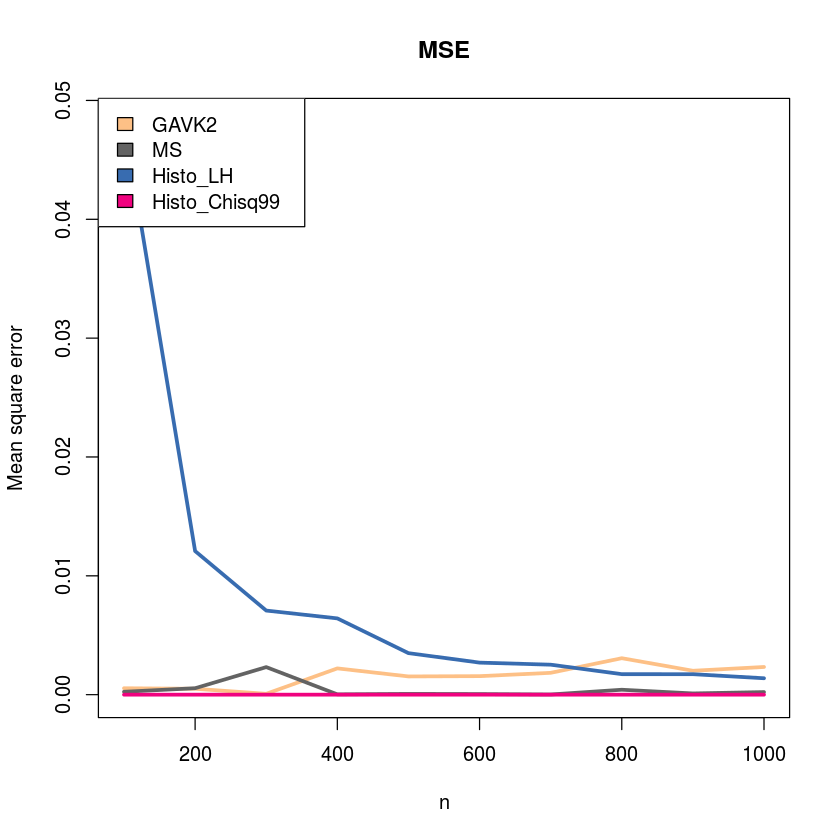

In [10]:
n = seq(100,1000,100)
plot(n, res_EX1.b[,4],
ylab="Mean square error",
main="MSE",
ylim=c(min(res_EX1.b[,4:7]),max(res_EX1.b[,4:7])),
type="l",
lwd=3,
col="#fdc086")
lines(n,res_EX1.b[,5], lwd=3, col="#636363")
lines(n,res_EX1.b[,6], lwd=3, col="#386cb0")
lines(n,res_EX1.b[,7], lwd=3, col="#f0027f")
legend("topleft",
c("GAVK2", "MS", "Histo_LH", "Histo_Chisq99"),
fill=c("#fdc086", "#636363", "#386cb0", "#f0027f")
)

EX.1.c

X ~ Continuous Unif(0, 4)      

Y = (X + NoiseY -2)/|X + NoiseY-2|     

Z = 2X + NoiseZ     

(X, Y, Z) ~ (Continuous, Discrete, Continuous)

I(Y;Z|X) = 0

In [11]:
EX1.c = function(n){
    x = runif(n, min=0, max=4)
    y = rep(0,n)
    z = rep(0,n)
    for(i in 1:n){
        y[i] = x[i] + rnorm(1)
        if(y[i]>=2){
            y[i] = 1
        }else{
            y[i] = -1
        }
        z[i] = 2*x[i] + rnorm(1)
     }
  return(data.frame(x,y,z))
}

In [12]:
res_EX1.c  = experTrigger(exper=EX1.c, xind=c(2), yind=c(3), zinds=c(1), isCat=c(2), trueI=0)

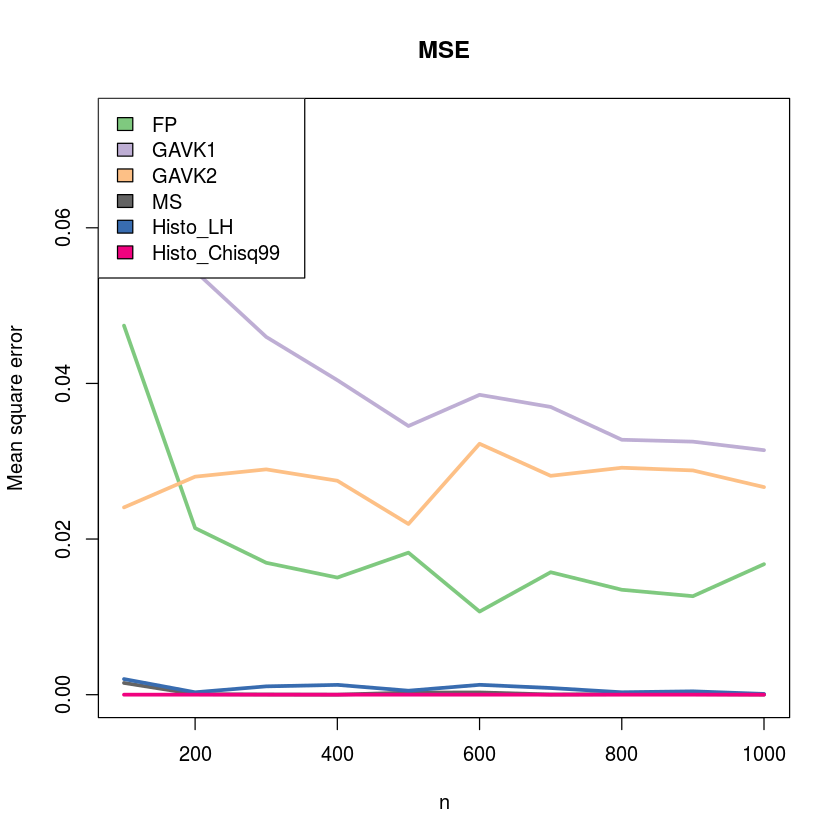

In [13]:
draw_MSE(res=res_EX1.c)

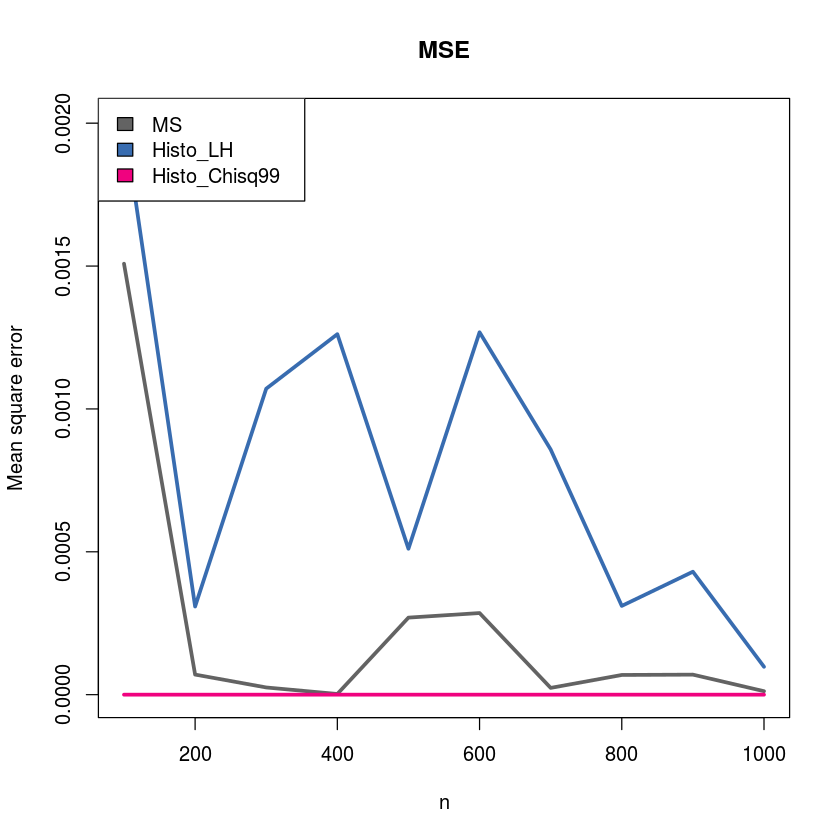

In [16]:
n = seq(100,1000,100)
plot(n, res_EX1.c[,5],
ylab="Mean square error",
main="MSE",
ylim=c(min(res_EX1.c[,5:7]),max(res_EX1.c[,5:7])),
type="l",
lwd=3,
col="#636363")
lines(n,res_EX1.c[,6], lwd=3, col="#386cb0")
lines(n,res_EX1.c[,7], lwd=3, col="#f0027f")
legend("topleft",
c("MS", "Histo_LH", "Histo_Chisq99"),
fill=c("#636363", "#386cb0", "#f0027f")
)

In [14]:
EX2.a = function(n){
    x = runif(n, min=0, max=4)
    y = rnorm(n, mean = 0, sd = 1)
    z = rep(0,n)
    for(i in 1:n){
        z[i] = x[i] + 2 * y[i] + rnorm(1)
    }
  return(data.frame(x,y,z))
}

In [17]:
res_EX2.a  = experTrigger(exper=EX2.a, xind=c(1), yind=c(2), zinds=c(3), isCat=c(), trueI=0)

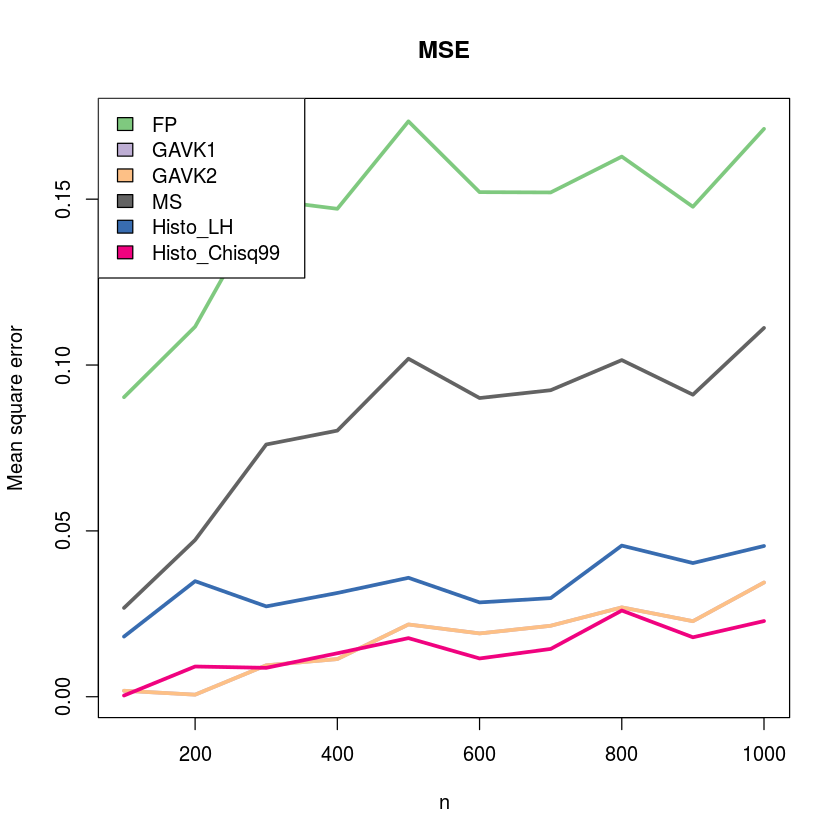

In [18]:
draw_MSE(res=res_EX2.a)